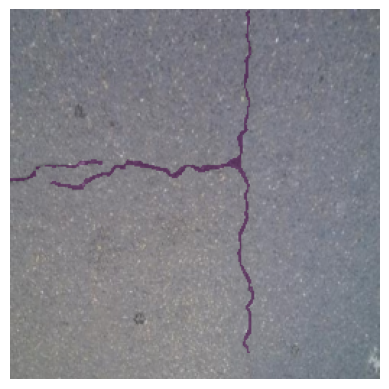

In [1]:
import albumentations as A
import torch
from torch.utils import data

from datasets.segmentation import CrackSeg
from train_utils import segmentation


TRAIN_PERCENTAGE = 0.8
augmentations = [
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=(-60, 60)),
    A.ColorJitter()

]
dataset = CrackSeg("data/crack-segmentation/dataset/image", "data/crack-segmentation/dataset/mask",
                   augmentations)
testset = CrackSeg("data/crack-segmentation/dataset/val_img", "data/crack-segmentation/dataset/val_msk")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
device = torch.device("cuda")
segmentation.show_label(dataset, 1)

In [2]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

In [3]:
from torch.nn import Conv2d, Flatten, Linear, Sequential

from models.tiny_crack_net import TinyCrackNet


NUM_CLASSES = 2
segmenter = TinyCrackNet(NUM_CLASSES)
segmenter.classifier = Sequential(
    segmenter.classifier,
    Flatten(1),
    Linear(NUM_CLASSES * 224 * 224, NUM_CLASSES)
)
segmenter.load_state_dict(torch.load("checkpoints/tcn_crack_class_096_epoch20.pth", weights_only=True))
segmenter.classifier = Conv2d(256, 1, 1, bias=False)
segmenter = segmenter.to(device)

In [4]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.sgd import SGD

from train_utils.segmentation import JointDiceBCEWithLogitsLoss


criterion = JointDiceBCEWithLogitsLoss(0.8)
optimizer = SGD(segmenter.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience=5)

Epoch 100/100: 100%|██████████| 214/214 [01:16<00:00,  2.81it/s]


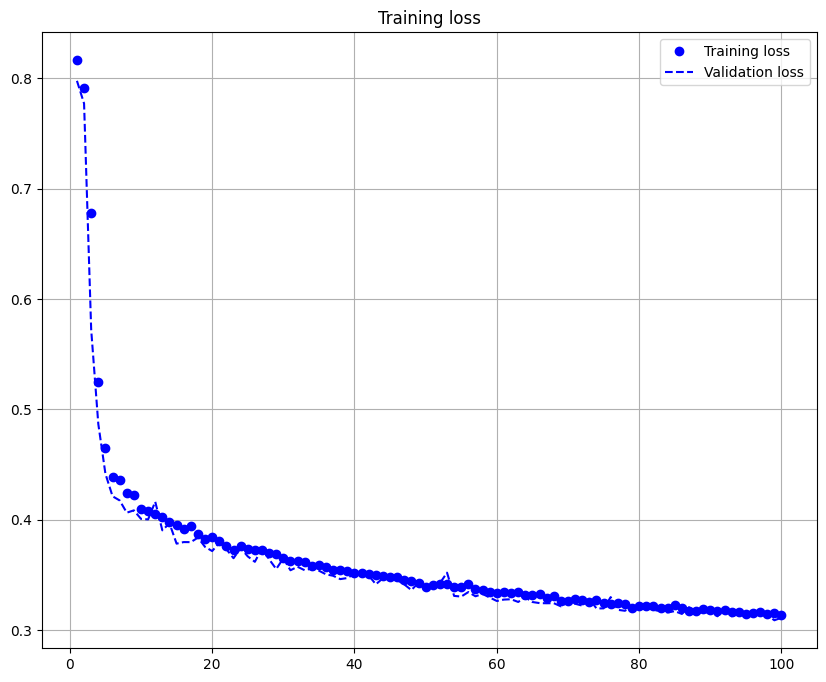

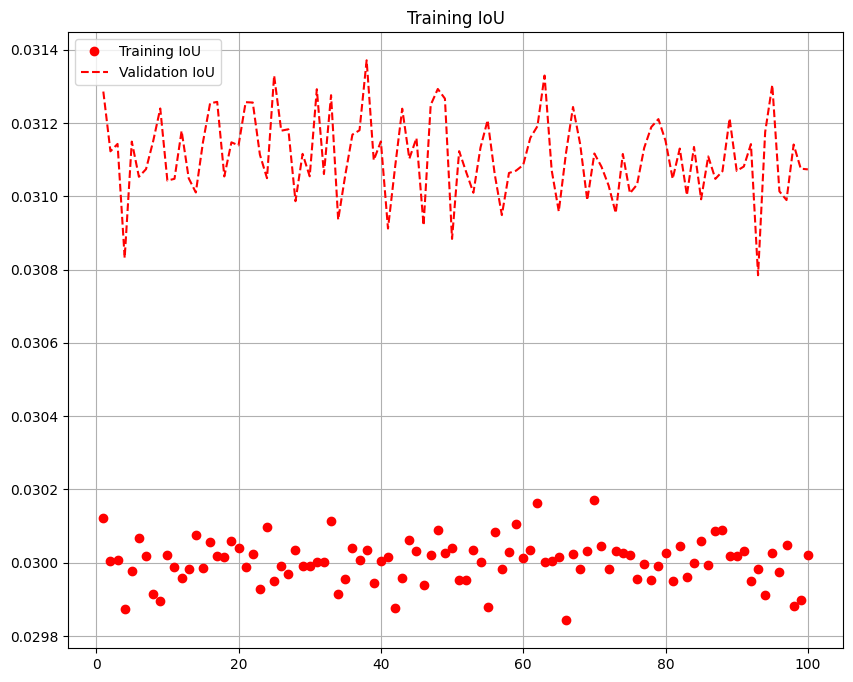

In [6]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 100,
                                                 optimizer, criterion, device, "tcn_cracks_joint_loss_augments", scheduler)
loss_hist.plot()
acc_hist.plot()

In [6]:
segmentation.print_model_performace(segmenter, testset, device)

Accuracy: 0.97529


In [8]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_0031_epoch50.pth", weights_only=True))

<All keys matched successfully>

In [4]:
from torch.nn import functional


model = segmenter
model.eval()
with torch.no_grad():
    for index in range(len(testset)):
        image, label = testset[index][0].to(device), testset[index][1].to(device)
        outputs = model(image.unsqueeze(0))
        predictions = (functional.sigmoid(outputs) > 0.5).int()
        if predictions.count_nonzero() > 0:
            """print(index)"""

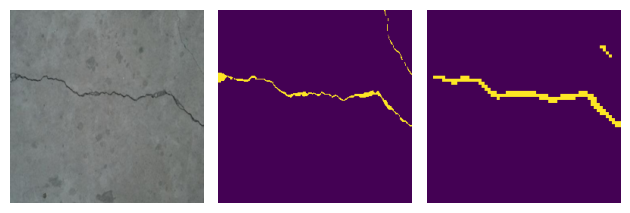

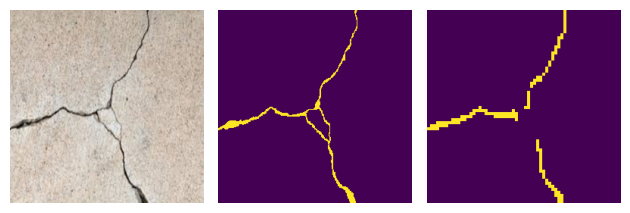

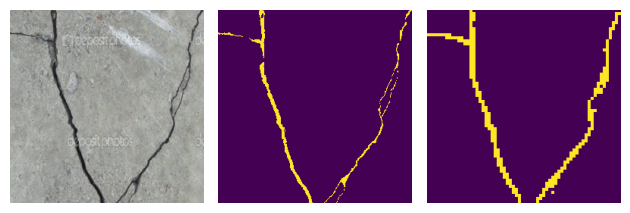

In [9]:
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)

### Augmentations

In [6]:
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_augments_0031_epoch100.pth", weights_only=True))

<All keys matched successfully>

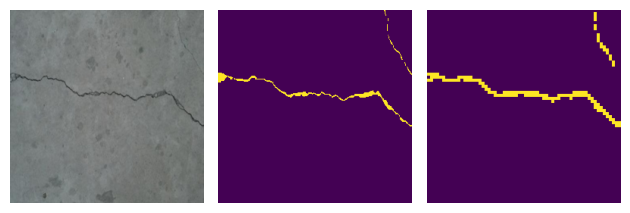

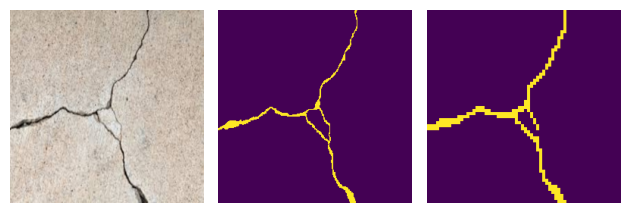

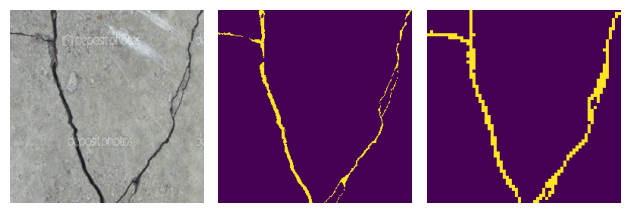

In [7]:
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)

## Pixel Average Error Distance

In [5]:
import albumentations as A
import torch
from torch.utils import data

from datasets.segmentation import CrackSeg
from train_utils import segmentation


TRAIN_PERCENTAGE = 0.8
augmentations = [
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=(-60, 60)),
    A.ColorJitter()

]
dataset = CrackSeg("data/crack-segmentation/dataset/image", "data/crack-segmentation/dataset/mask",
                   augmentations)
testset = CrackSeg("data/crack-segmentation/dataset/val_img", "data/crack-segmentation/dataset/val_msk")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
device = torch.device("cuda")

In [6]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

In [8]:
from models.tiny_crack_net import TinyCrackNet


segmenter = TinyCrackNet(1)
segmenter.load_state_dict(torch.load("checkpoints/tcn_cracks_joint_loss_k5_003_epoch150.pth", weights_only=True))
segmenter = segmenter.to(device)

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.adam import Adam

from train_utils.segmentation import PAEDLoss


criterion = PAEDLoss()
optimizer = Adam(segmenter.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience=10)

Epoch 30/30: 100%|██████████| 214/214 [01:43<00:00,  2.07it/s]


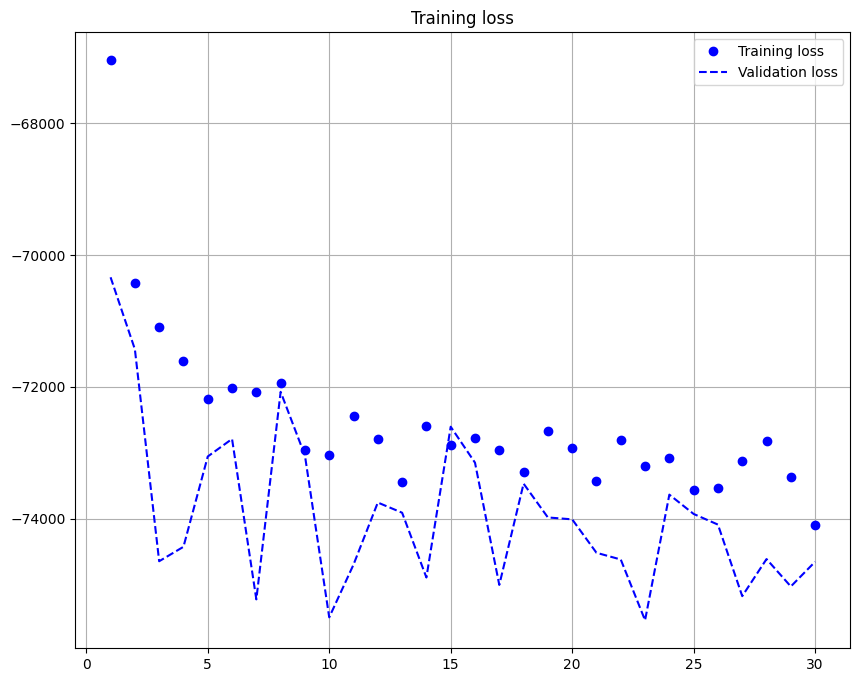

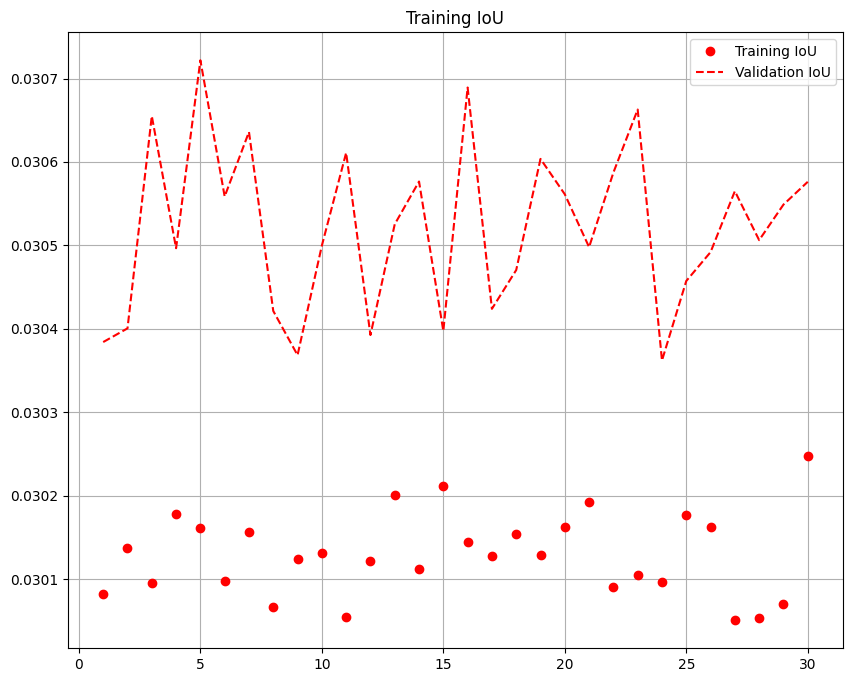

In [10]:
loss_hist, acc_hist = segmentation.train_model(segmenter, train_loader, validation_loader, 30,
                                                 optimizer, criterion, device, "tcn_cracks_paed_augments", scheduler)
loss_hist.plot()
acc_hist.plot()

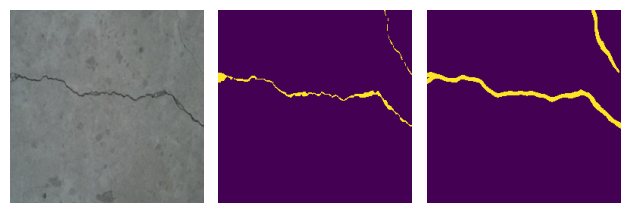

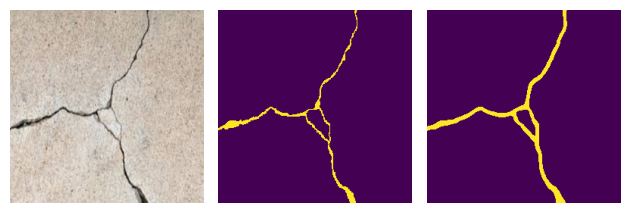

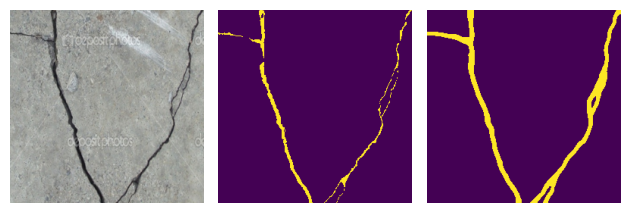

In [12]:
segmentation.compare_prediction(segmenter, testset, 0, device)
segmentation.compare_prediction(segmenter, testset, 1, device)
segmentation.compare_prediction(segmenter, testset, 2, device)